[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mlexchange/als_ml_tutorial/blob/main/3_4_ML_tutorial_CNN.ipynb)

## 3.4 Convolutional Autoencoders

A convolutional autoencoder is a type of network that uses a series of convolutional layers within it's architecture. These convolutional layers apply a set of filters, also known as kernels, to overlapping areas of the input data, which outputs a feature map.

The following correspond to some key parameters in a convolutional layer:
 - Kernel size: Size of the filter window
 - Stride: Step size of the filter window moving over the input
 - Padding: Amount of padding around the input
 - Dilation: Space between filter elements

More information can be found: [Conv2D in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)

### 3.4.1 Network architecture

The following cell defines a convolutional neural network with an encoder-decoder architecture. The encoder consists on a series of convolutional layers, followed by an activation layer, and a pooling layer, which extract relevant features from the input while downsampling its feature maps. On the other hand, the decoder performs the opposite operation with a series of transposed convolutional layers followed by activation layers, which upsample the latent space to reconstruct the original information. It is important to clarify that dense layers are used at the bottleneck of this architecture to further minimize the dimension of the latent space.

In [1]:
from torch.nn import Module, Sequential
from torch.nn import Conv2d, ReLU, MaxPool2d, ConvTranspose2d, Sigmoid, Flatten, Unflatten, Linear

class CNN(Module):
    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.encoder = Sequential(
            Conv2d(in_channels=input_shape[0], out_channels=32, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2),
            Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2),
            Flatten(),
            Linear(64* (input_shape[1] // 4) * (input_shape[2] // 4), latent_dim)
        )
        self.decoder = Sequential(
            Linear(latent_dim, 64 * (input_shape[1] // 4) * (input_shape[2] // 4)),
            Unflatten(1, (64, input_shape[1] // 4, input_shape[2] // 4)),
            ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, 
                            output_padding=1),
            ReLU(),
            ConvTranspose2d(in_channels=32, out_channels=input_shape[0], kernel_size=3, stride=2, 
                            padding=1, output_padding=1),
            Sigmoid()
        )
    
    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return z

#### Before moving forward, let's check our architecture closely by using the size of our dataset

In [2]:
from torchsummary import summary

auto_cnn = CNN(input_shape=(1, 64, 64), latent_dim=1000)

summary(auto_cnn, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
              ReLU-2           [-1, 32, 64, 64]               0
         MaxPool2d-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,496
              ReLU-5           [-1, 64, 32, 32]               0
         MaxPool2d-6           [-1, 64, 16, 16]               0
           Flatten-7                [-1, 16384]               0
            Linear-8                 [-1, 1000]      16,385,000
            Linear-9                [-1, 16384]      16,400,384
        Unflatten-10           [-1, 64, 16, 16]               0
  ConvTranspose2d-11           [-1, 32, 32, 32]          18,464
             ReLU-12           [-1, 32, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 64, 64]             289
          Sigmoid-14            [-1, 1,

### 3.4.2 Data Preparation

Let's prepare our training and validation sets as explained in section 2.4

In [3]:
import os
from torch.utils.data import Dataset
from PIL import Image

class FileDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        '''
        Custom dataset to read image files
        '''
        self.image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir) 
                            if not filename.startswith('.')]
        self.transform = transform
    
    def __getitem__(self, index):
        '''
        Retrieve item by using the corresponding image path
        '''
        image = Image.open(self.image_paths[index])
        if self.transform:
            image = self.transform(image)
        return image
    
    def __len__(self):
        '''
        Redefine how to calculate the length of our dataset
        '''
        return len(self.image_paths)

#### Let's add the path to the dataset and any data transformations

In [ ]:
# Download the data (400 scattering images 1.3Mb)
# If not on Google Colab or on a machine without wget, comment out the two cells below,
# download the linked file, and unzip in the directory of this notebook
!wget -q 'https://drive.google.com/uc?id=1RTObsZOHLS4RUnwCegoxXD5EktvrSeI5' -O 'data_64x64_400.zip'
!unzip -q -n 'data_64x64_400.zip' && rm 'data_64x64_400.zip'
data_directory = "./data_64x64_400"

In [4]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = FileDataset(data_directory, transform=data_transform)

# Split the dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### 3.4.3 Model Training

As shown in previous sections, let's define our training parameters (loss funcion, optimizer, learning rate, etc) and start the training process.

In [5]:
import torch
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
auto_cnn.to(device)

Device: cpu


CNN(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=16384, out_features=1000, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=16384, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(64, 16, 16))
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [6]:
from torch.nn import MSELoss
from torch.optim import AdamW

# Training parameters
criterion = MSELoss()
optimizer = AdamW(auto_cnn.parameters(), lr=0.001)   #0.005
num_epochs = 50     #20

epoch_loss = []
epoch_val_loss = []
for epoch in range(num_epochs):
    auto_cnn.train()                        # Set the model to training mode
    for input_batch in train_loader:
        optimizer.zero_grad()               # Zero the gradients
        out_batch = auto_cnn(input_batch.to(device))          # Forward pass
        loss = criterion(out_batch, input_batch)   # Compute loss
        loss.backward()                     # Backpropagation
        optimizer.step()                    # Update weights
    # auto_cnn.eval()
    val_loss = 0.0
    with torch.no_grad():                   # Validation
        for val_batch in val_loader:
            out_val_batch = auto_cnn(val_batch.to(device))
            val_batch_loss = criterion(out_val_batch, val_batch)
            val_loss += val_batch_loss.item()
    avg_val_loss = val_loss / len(val_loader)
    epoch_loss.append(loss.detach().numpy())
    epoch_val_loss.append(avg_val_loss)
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}, Validation Loss: {avg_val_loss:.6f}')

# Save model
torch.save(auto_cnn.state_dict(), 'trained_cnn_tutorial.pth')

Epoch [10/50], Loss: 0.006231, Validation Loss: 0.006136
Epoch [20/50], Loss: 0.004142, Validation Loss: 0.003466
Epoch [30/50], Loss: 0.002113, Validation Loss: 0.002554
Epoch [40/50], Loss: 0.001372, Validation Loss: 0.002126
Epoch [50/50], Loss: 0.001202, Validation Loss: 0.001951


#### Let's check the loss plot

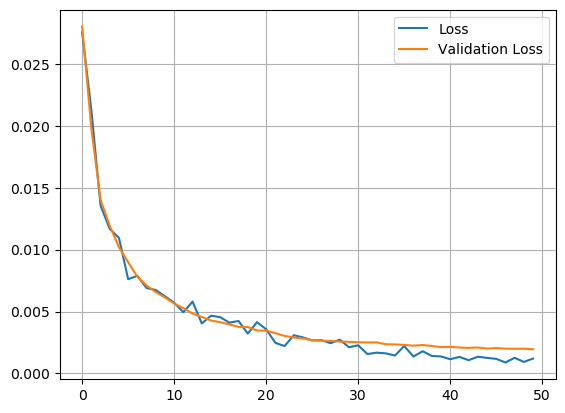

In [7]:
import matplotlib.pyplot as plt

plt.plot(epoch_loss)
plt.plot(epoch_val_loss)
plt.legend(["Loss", "Validation Loss"])
plt.grid()

### 3.4.4 Evaluation

We can use our validation set for evaluation purposes. To do this, let's first obtain the reconstructed images by using the previously trained network.

In [8]:
import numpy as np
import random

out_val = []
with torch.no_grad(): 
    for batch in val_loader:
        reconstructed_batch = auto_cnn(batch.to(device))
        out_val.append(reconstructed_batch.detach().cpu().numpy())
reconstructed_set = np.vstack(out_val)

#### Then, we can visualize some of these results as follows:

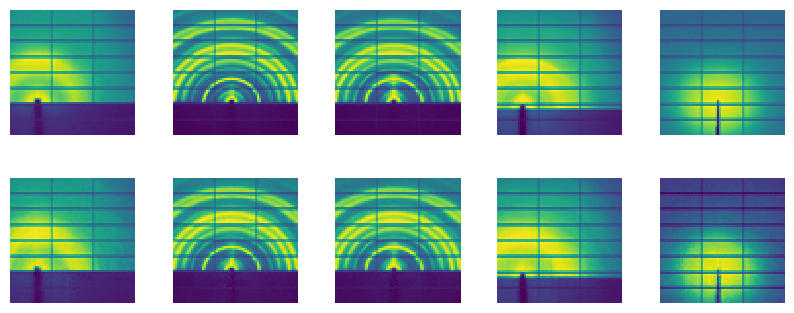

In [22]:
val_set = np.vstack(list(iter(val_loader)))

# Randomly selectes 5 images from the validation set
indxs = random.sample(range(len(reconstructed_set)), 5)

fig, axs = plt.subplots(2, 5, figsize=(10,4))
for i in range(5):
    original_img = val_set[indxs[i]]
    reconstructed_img = reconstructed_set[indxs[i]]
    axs[0, i].imshow(np.squeeze(original_img))
    axs[0, i].axis('off')
    axs[1, i].imshow(np.squeeze(reconstructed_img))
    axs[1, i].axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.2)

### 3.4.5 Latent Space Exploration with UMAP

Let's further analyze the latent space with UMAP

In [7]:
# Load the trained model if needed
import torch
auto_cnn = CNN(input_shape=(1, 64, 64), latent_dim=1000)
auto_cnn.load_state_dict(torch.load('trained_cnn_tutorial.pth'))
auto_cnn.eval()
auto_cnn.to(device)

#### Extract feature vectors with trained neural network

In [8]:
f_vec = []
with torch.no_grad(): 
    for batch in val_loader:
        batch_f_vec = auto_cnn.encoder(batch.to(device))
        f_vec.append(batch_f_vec.detach().cpu().numpy())
f_vec = np.vstack(f_vec)

In [9]:
f_vec.shape

(80, 1000)

#### Apply UMAP

In [ ]:
# Install umap if needed
!pip -q install umap-learn

In [25]:
import umap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def perform_umap(f_vec, n_neighbors=None, min_dist=None, random_state=None):
    # Perform U-MAP
    if n_neighbors is None and min_dist is None:
        umap_model = umap.UMAP(n_components=2, 
                               random_state=random_state)
    else:
        umap_model = umap.UMAP(n_components=2, 
                               n_neighbors=n_neighbors,
                               min_dist=min_dist,
                               random_state=random_state)
    umap_result = umap_model.fit_transform(f_vec)
    return umap_result

def plot_reduction(reduced_data, original_data, category=None, zoom=0.35):
    """ This function plots the dimensionally reduced data."""
    
    if 'pca' in category.lower():
        title = 'PCA Results'; xtitle = 'Principal Component 1'; ytitle = 'Principal Component 2'
    elif ('umap' in category.lower()) or ('u-map' in category.lower()):
        title = 'U-Map Results'; xtitle = 'U-Map Dimension 1'; ytitle = 'U-Map Dimension 2'
    else:
        title = 'Dimensionality Reduction Results'; xtitle = 'Reduced Dimension 1'; ytitle = 'Reduced Dimension 2'
    
    plt.figure(figsize=(10, 12))
    plt.rcParams.update({'font.size': 14})
    
    # Plot 2d reduction
    plt.subplot(2,1,1)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
    plt.title(title); plt.xlabel(xtitle); plt.ylabel(ytitle)
    plt.grid(True)

    # Plot 2d reduction with original images
    plt.subplot(2,1,2)
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='o', s=30, c='b')

    for i in range(len(reduced_data)):
        imagebox = OffsetImage(original_data[i], zoom=zoom)  # Adjust the zoom factor as needed
        ab = AnnotationBbox(imagebox, (reduced_data[i, 0], reduced_data[i, 1]), frameon=False)
        plt.gca().add_artist(ab)

    plt.title('Original Images Embedded')
    plt.xlabel(xtitle); plt.ylabel(ytitle); plt.title(title + ' with Original Images')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    pass

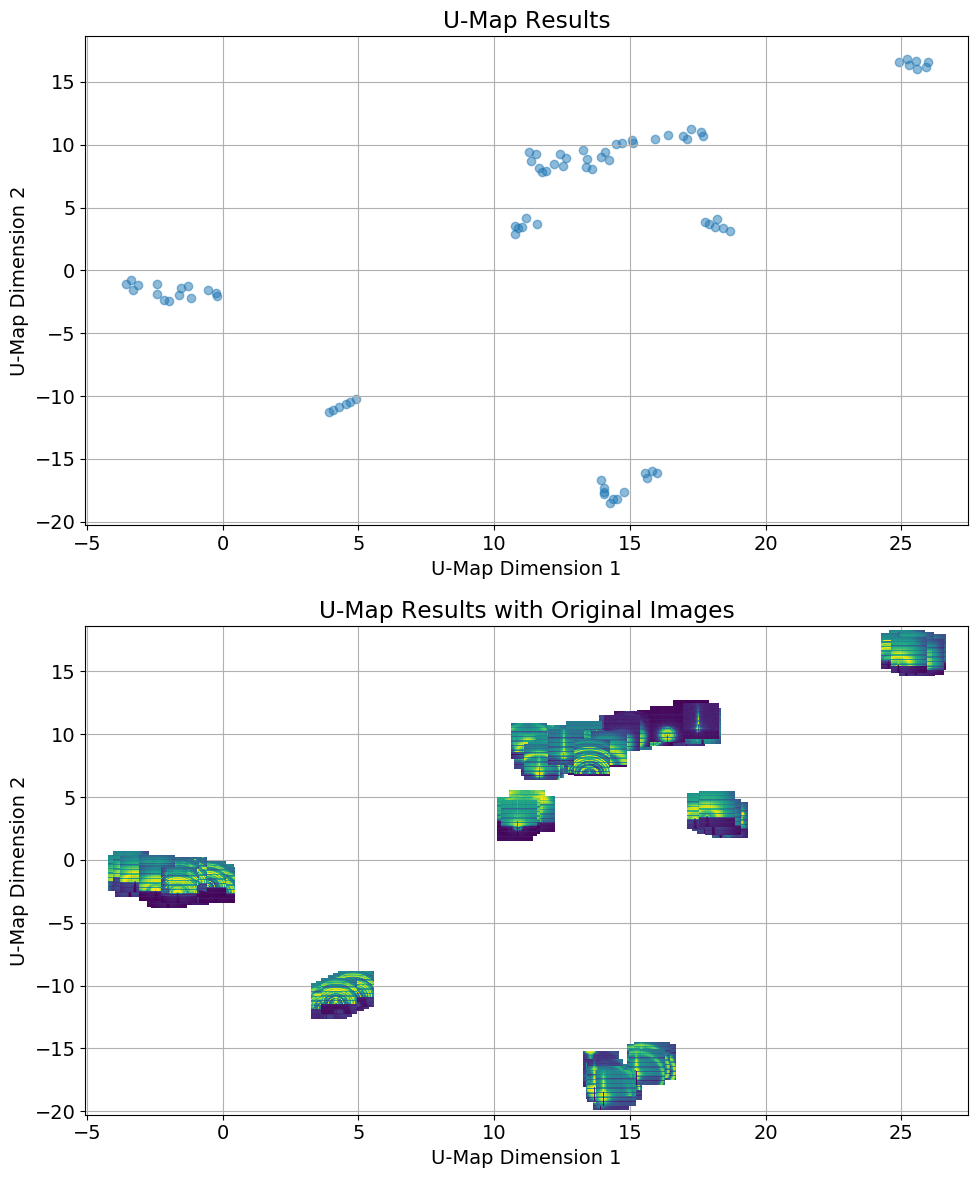

In [28]:
umap_features = perform_umap(f_vec, n_neighbors=5, min_dist=0.5)

plot_reduction(umap_features, np.squeeze(val_set), category='umap', zoom=0.4)